# About this notebooke

This notebook contains all the preliminary results for our AIED 2020 paper.

In [17]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare data
## Load scores and sequence data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=False)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Width, Concentration, Separation, Area


We grab the sequences

In [3]:
import pickle
%aimport utils_sequence_parsing
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

We transform the sequences by blocking certain actions, removing others, merging some and generalizing

In [4]:
transformed_seqs = {}
for sim,seqs_by_student in all_seqs.iteritems():
    transformed_seqs[sim] = {}
    for sid,seq in seqs_by_student.iteritems():
        seq = copy.copy(seq)
        seq.standard_transformation()
        transformed_seqs[sim][sid] = seq

## Split groups

In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index','sim'], aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)

In [8]:
def make_group(row):
    if row['pre']==2:
        return 'H'
    elif row['pre']==0 and row['main']==0:
        return 'LU'
    elif row['pre']==0 and row['main']==1:
        return 'LP'
    elif row['pre']==0 and row['main']==2:
        return 'LP'
    elif row['pre']==1 and row['main']==0:
        return 'H'
    elif row['pre']==1 and row['main']==1:
        return 'H'
    elif row['pre']==1 and row['main']==2:
        return 'H'
    else:
        print row
    
scores['group'] = scores.apply(make_group,axis=1)

In [9]:
scores.groupby(['sim_index','group']).describe()

main                                        pre              \
                count  mean   std  min  25%  50%  75%  max count  mean   std   
sim_index group                                                                
1         H      14.0  1.43  0.85  0.0  1.0  2.0  2.0  2.0  14.0  1.57  0.51   
          LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.00  0.00   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.00  0.00   
2         H      13.0  1.77  0.60  0.0  2.0  2.0  2.0  2.0  13.0  1.31  0.48   
          LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.00  0.00   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.00  0.00   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         H      1.0  1.0  2.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         H      1.0  1.0  1.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

In [10]:
scores.groupby(['sim','group']).describe()

main                                        pre                   \
          count  mean   std  min  25%  50%  75%  max count  mean   std  min   
sim group                                                                     
C   H      14.0  1.50  0.76  0.0  1.0  2.0  2.0  2.0  14.0  1.43  0.51  1.0   
    LP     53.0  1.62  0.49  1.0  1.0  2.0  2.0  2.0  53.0  0.00  0.00  0.0   
    LU     80.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  80.0  0.00  0.00  0.0   
L   H      13.0  1.69  0.75  0.0  2.0  2.0  2.0  2.0  13.0  1.46  0.52  1.0   
    LP     66.0  1.77  0.42  1.0  2.0  2.0  2.0  2.0  66.0  0.00  0.00  0.0   
    LU     68.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  68.0  0.00  0.00  0.0   

                               
           25%  50%  75%  max  
sim group                      
C   H      1.0  1.0  2.0  2.0  
    LP     0.0  0.0  0.0  0.0  
    LU     0.0  0.0  0.0  0.0  
L   H      1.0  1.0  2.0  2.0  
    LP     0.0  0.0  0.0  0.0  
    LU     0.0  0.0  0.0  0.0

By sim index and by sim order, there are too few Highpres to include them so we ignore them.

In [11]:
scores = scores[scores['group'].isin(['LU','LP'])]
scores.groupby(['sim_index','group']).describe()

main                                        pre            \
                count  mean   std  min  25%  50%  75%  max count mean  std   
sim_index group                                                              
1         LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0  0.0   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0  0.0   
2         LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0  0.0   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0  0.0   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

# Results

## pre and main scores

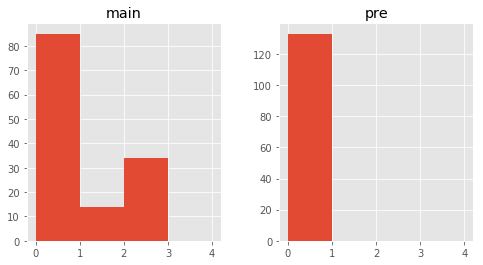

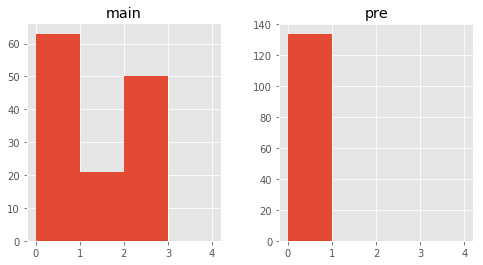

In [21]:
plot = scores.groupby('sim_index').hist(bins=range(5))

## groupnumbers and transition

## number of actions

## number of pauses

## frequency of actions

### How to people transition from one group to another from activity 1 to 2?

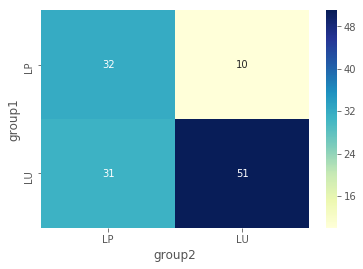

In [14]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
df_all.dropna(inplace=True)
combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
combogroups.drop_duplicates(inplace=True)
sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

The bulk of students go from LU to LP or remain in their original group.

# Comparison single action LULU LULP

In [ ]:
levels = ['LULU','LULP']

students_by_attribute={}
students_by_attribute['LULU'] = list(combogroups[(combogroups['group1']=='LU')&(combogroups['group2']=='LU')]['sid'].unique())
students_by_attribute['LULP'] = list(combogroups[(combogroups['group1']=='LU')&(combogroups['group2']=='LP')]['sid'].unique())

for level in levels:
    print level, len(students_by_attribute[level])
    
df = df_all[(df_all['sid'].isin(students_by_attribute['LULU'])) | (df_all['sid'].isin(students_by_attribute['LULP']))]
df = df[df['sim_index']==1]
df.groupby(['sim_index','group','variable']).describe()

In [ ]:
level1 = 'LULU'
level2 = 'LULP'
levels = [level1, level2]
#We split activities into 3 time bins
num_bins = 3
#Sequences of action of interest can be a minimum and max length
shortest_seq_length = 1
longest_seq_length = 10
# for mining sequences in large groups, we want to make sure we find interesting sequences that have been done by a minimum number of people.
# Thus we use a cut off of 0.3-0.5 to only analyze sequences done by at least 30-50% of students within a group.
# Thus the groups can have slightly different sizes.
cut_off = 0.33
freqs = get_frequencies_by_bin(seqs_dict,timecoords_dict, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)

In [ ]:
#single actions
seqs = ['C2_qual', 'C2_quant','C3_qual', 'C3_quant','Cm_qual', 'Cm_quant', 'G_add', 'G_add_fail', 'G_axis_outcome', 'G_axis_quant', 'G_axis_trialnumber', 'G_remove', 'G_scale_inverse', 'G_scale_linear', 'G_scale_log', 'P', 'Switch_quant', 'T_add', 'T_remove', 'V_detector', 'V_laser', 'V_other', 'V_qual', 'V_quant']

In [ ]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig, axes = plt.subplots(len(seqs)/2+1,2,figsize=(16,len(seqs)*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


for i,s in enumerate(seqs):
#     print s
    ax = axes.flatten()[i]
    use = []
    for i,l in enumerate(levels):
        student_in_group = students_by_attribute[l]
        use.append([])
        for student in student_in_group:
            if s in freqs[student][0].keys():
                use[i].append(freqs[student][0][s])
            else:
                use[i].append(0)
                
    print s, use
    bins = range(max(use[0]+use[1]))
    a = sns.distplot(use[0],color='red',ax=ax,kde=False,bins=bins,norm_hist=True)
    sns.distplot(use[1],color='blue',ax=ax,kde=False,bins=bins,norm_hist=True)
    ax.set_title(s);